# Make efficiency map plots for trained fitters

In [2]:
import train as tn
reload(tn)

import plotting
reload(plotting)

import util as ut

import matplotlib.pyplot as plt
#plt.style.use('seaborn-ticks')
plt.style.use('seaborn-poster')
%matplotlib inline
#%matplotlib notebook

import numpy as np

from pprint import pprint

import itertools

# import xgboost

Welcome to ROOTaaS 6.06/08


In [3]:
#note that the loading option is True by default
ut.defaultParameters(dataDir='./data', inputName="effGenVarClassBinnedRecoPtBinnedRecoNjets2p5_out", inputDir='./classifiers')
ut.setParams()
effFitter = ut.loadOrMake()

entered config files named my_train_config
None
Load object with the name effGenVarClassBinnedRecoPtBinnedRecoNjets2p5_out and the following paramters 
./classifiers
./classifiers/effGenVarClassBinnedRecoPtBinnedRecoNjets2p5_out.pkl.gz
loading pickle ./classifiers/effGenVarClassBinnedRecoPtBinnedRecoNjets2p5_out.pkl.gz
loading data ./classifiers/effGenVarClassBinnedRecoPtBinnedRecoNjets2p5_out.root
Index([u'absweight', u'class', u'genJet2p5Pt0', u'genJet2p5Pt1',
       u'genJet2p5Pt2', u'genJet2p5Pt3', u'genJet2p5Rapidity0',
       u'genJet2p5Rapidity1', u'genJet2p5Rapidity2', u'genJet2p5Rapidity3',
       u'genNjets2p5', u'genPt', u'genRapidity', u'recoNjets2p5', u'recoPt',
       u'recoRapidity', u'weight', u'proc', u'absGenRapidity', u'recoPtBin',
       u'recoPtCat', u'recoNjets2p5Bin', u'recoNjets2p5Cat', u'class_prob_0',
       u'class_prob_1', u'class_prob_2', u'class_prob_3', u'recoPtCat_prob_0',
       u'recoPtCat_prob_1', u'recoPtCat_prob_2', u'recoPtCat_prob_3',
       u'rec

## projection on the following 2 variables

In [4]:
x_var = 'genJet2p5Rapidity0'
y_var = 'genJet2p5Pt0'

In [5]:
def GetBins (x_pt, y_pt, x_name, y_name) :
    N_PtBins = 8
    N_RapidityBins = 8
    if (x_pt and y_pt) :
        return { x_name : dict(boundaries=np.append(np.linspace(0,300.,10),1000),overflow=False), 
                       y_name : dict(boundaries=np.append(np.linspace(0,300.,10),1000),overflow=False)
            }   
    else :
        if x_pt :
            return { x_name : dict(boundaries=np.append(np.linspace(0,300.,10),1000),overflow=False), 
                           y_name : dict(boundaries=np.linspace(-3,3.,8),overflow=False)
                          }
        if y_pt :
            return { x_name : dict(boundaries=np.linspace(-3,3.,8),overflow=False), 
                           y_name : dict(boundaries=np.append(np.linspace(0,300.,10),1000),overflow=False)
                          }
    return { x_name : dict(boundaries=np.linspace(-3,3.,8),overflow=False), 
             y_name : dict(boundaries=np.linspace(-3,3.,8),overflow=False)
                        }

### define bins in genJet2p5Rapidity0 and genJet2p5Pt0

In [6]:
defineBins = GetBins(x_pt=False,y_pt=True,x_name=x_var,y_name=y_var)

In [7]:
ut.runDefineBins(effFitter,defineBins)

### Extract data frame and start getting the probas in a binned way

In [8]:
df = effFitter.df
first_train_evt = int(round(df.index.size*(1.-effFitter.split_frac)))

#take the test sample 
df_test = df[:first_train_evt]

In [9]:
def weighted_average(df_name, column_name, weight_name=None):
    """
    This function computes the weighted average of the quantity column_name
    stared in the pandas dataframe df_name. In case no weights are given
    or if they sum up to zero, the mean is returned instead.
    :params 
            df_name :
        column_name :
        weight_name :
    :retruns
                    :
    """
    d = df_name[column_name]
    w = df_name[weight_name]
    #print(len(w))
    if (weight_name == None) :
        return float(d.mean())
    else :
        try:
            return (d * w).sum() / float(w.sum())
        except ZeroDivisionError:
            return float(d.mean())

In [10]:
def weight_freq (df_name, column_name, equal_to, weight_name) :
    df = df_name#[df_name[column_name]==equal_to]
    
    w_all = df[weight_name].sum()
    w_PartPhaseSpace = df[df[column_name] == equal_to][weight_name].sum()
    #print(w_all)
    #print(w_PartPhaseSpace)
    return w_PartPhaseSpace / w_all

In [65]:
def plot_imshow(groupby_objects, 
                          titles=[],
                        x_lab = None,
                        y_lab = None,
                          cmap=plt.cm.Blues,
                   effTag=False):
    
    fig = plt.figure(figsize=(10,10))
    
    max_col = 1.
    min_col = 0.
   
    
    for i, r in enumerate(groupby_objects) :
    
        x,y = r.index.levels
        cm = r.values.reshape(len(x),len(y))
        
        if (cm.max() < max_col) :
            max_col = cm.max()
        if (cm.min() > min_col) :
            min_col = cm.min()
        
        plt.subplot('12'+str(i+1))
    
        plt.imshow(cm, interpolation='nearest', cmap=cmap,origin='lower')
        plt.title(titles[i])
    
        xtick_marks = np.arange(len(x))
        ytick_marks = np.arange(len(y))
    
    
        plt.xticks(xtick_marks, xtick_marks)
        plt.yticks(ytick_marks, ytick_marks)

    
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, np.round(cm[i, j],2), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    
        plt.tight_layout()
        plt.xlabel(x_lab)
        if i == 0 :
            plt.ylabel(y_lab)
    
    plt.clim(min_col,max_col)
    fig.subplots_adjust(top=0.98)   
    cbar_ax = fig.add_axes([0.15, 0.97, 0.7, 0.02])
    plt.colorbar(cax=cbar_ax,orientation='horizontal')#,norm=plt.colors.Normalize(vmin=min_col,vmax=max_col))
    
    if effTag :
        plot_imshow(groupby_objects, titles=titles=['predicted (clf) reco eff', 'true data reco eff'],
                        x_lab = x_lab, y_lab = y_lab, cmap=plt.cm.Reds, effTag=False)
        
    

SyntaxError: invalid syntax (<ipython-input-65-c11093ce26e7>, line 54)

In [68]:
def NminusOne (N) :
    print(N)
    if (N>0) :
        N-=1
        NminusOne(N)

In [69]:
NminusOne(10)

10
9
8
7
6
5
4
3
2
1
0


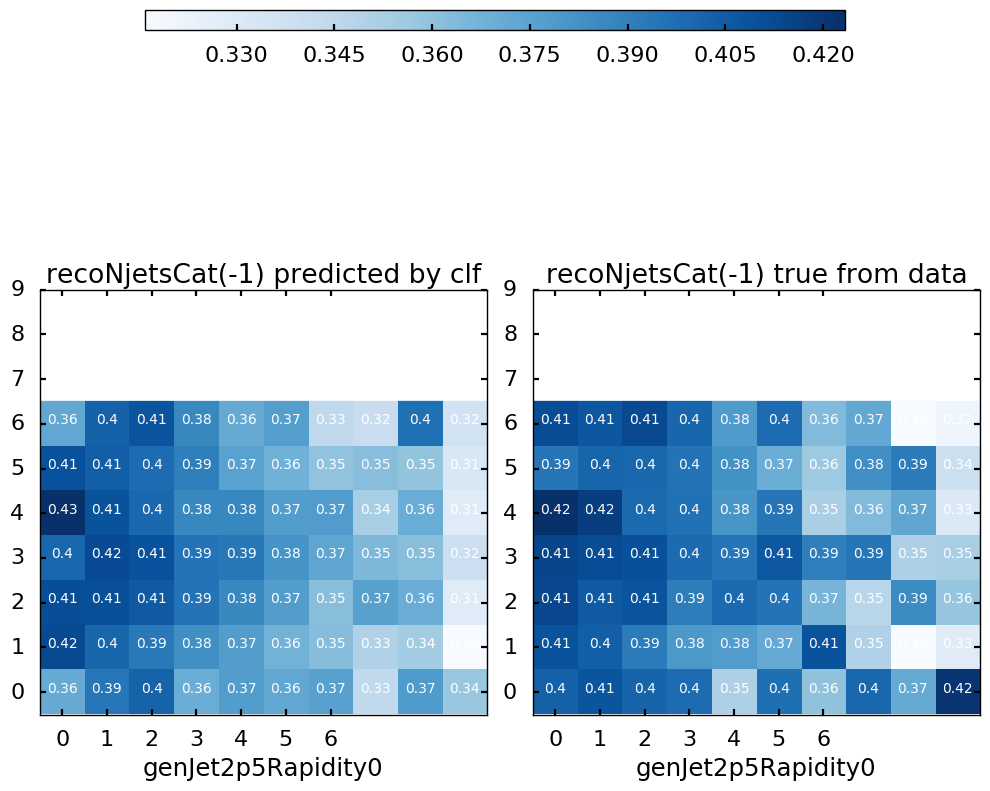

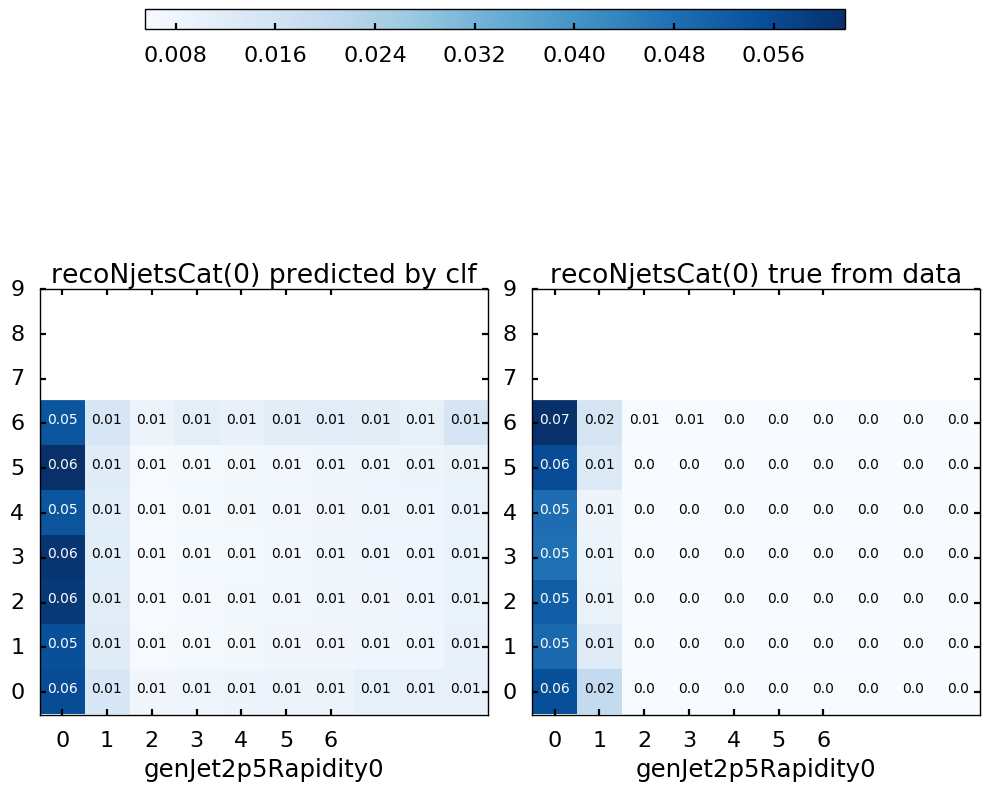

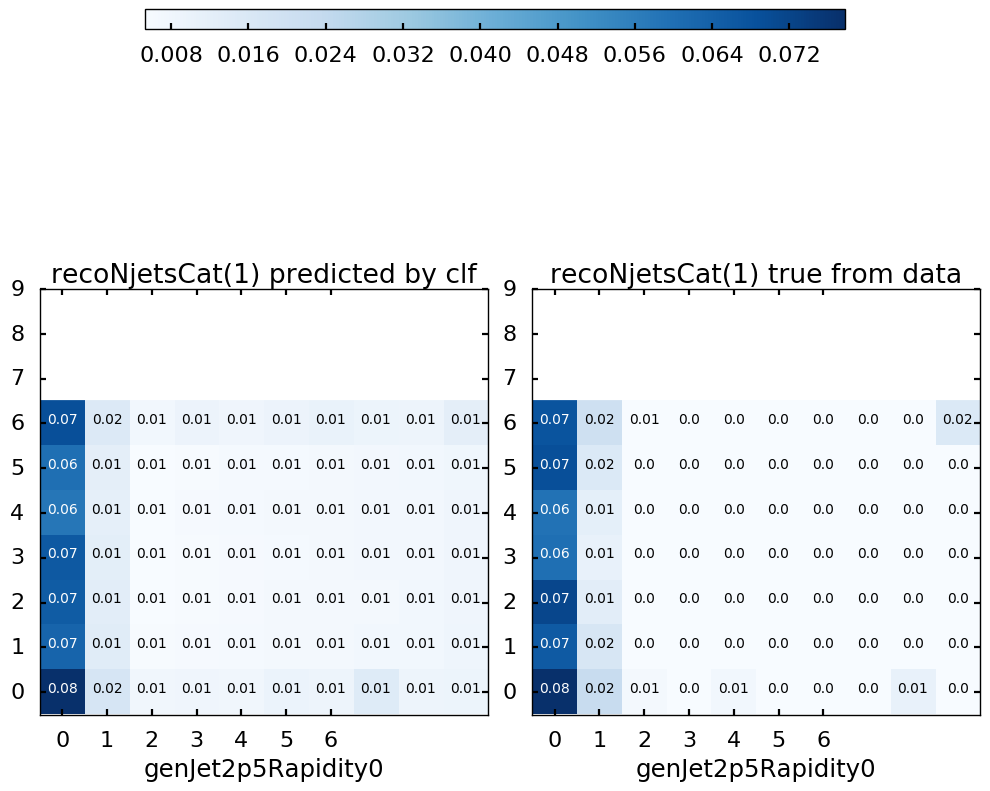

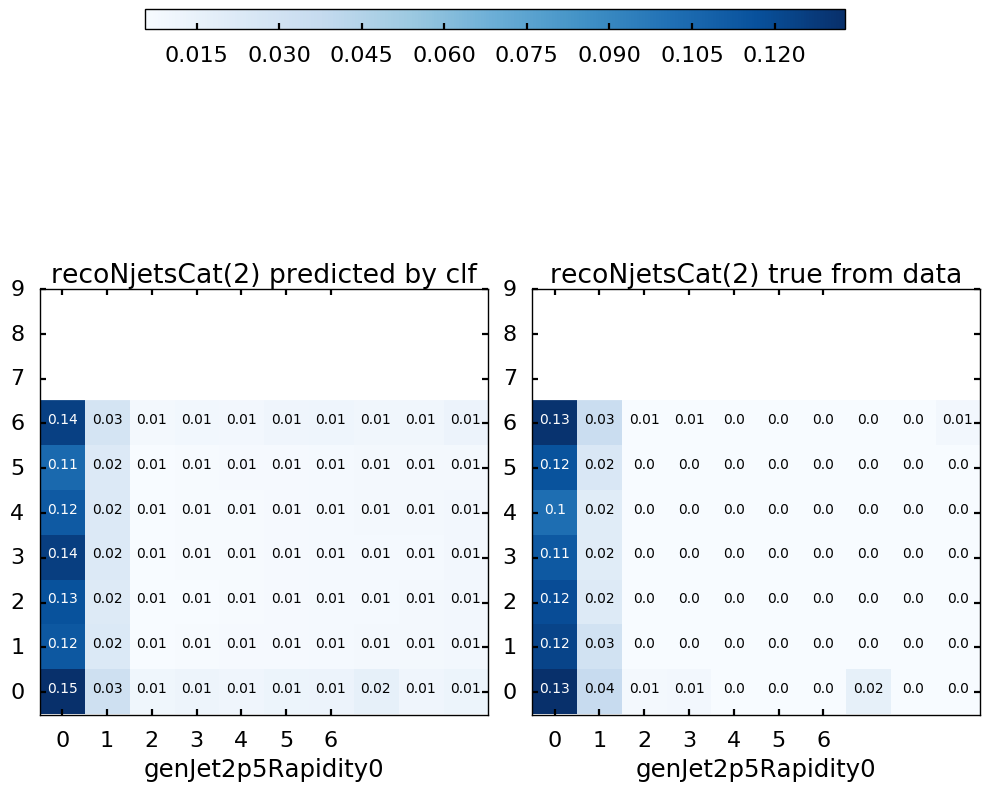

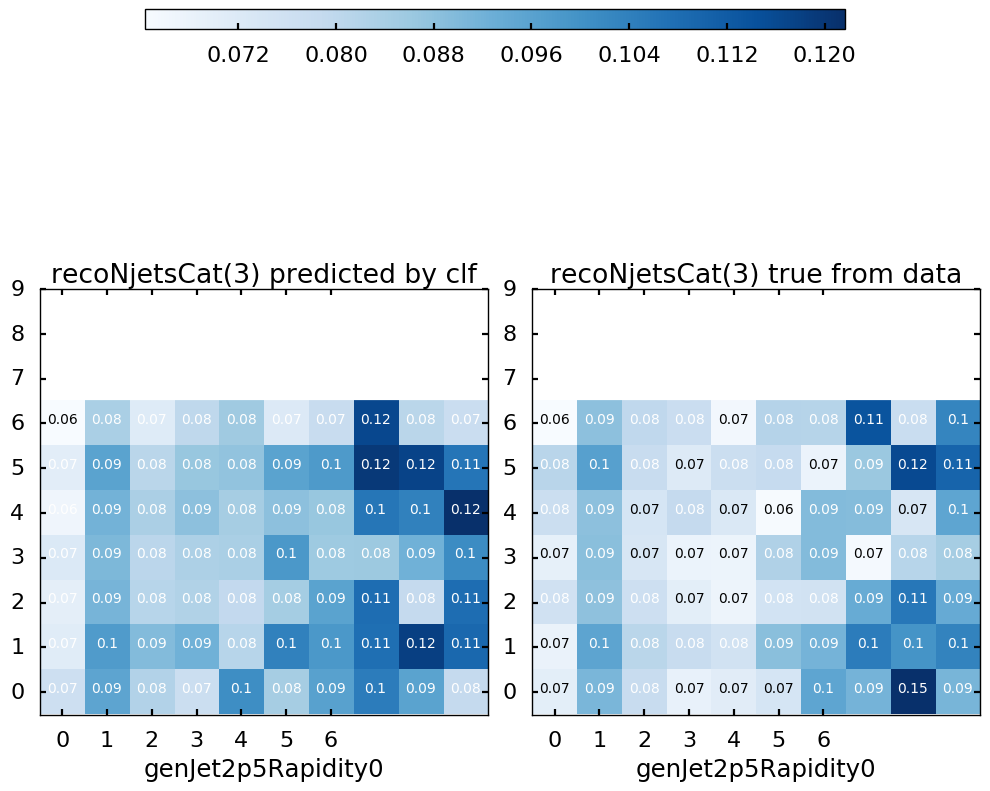

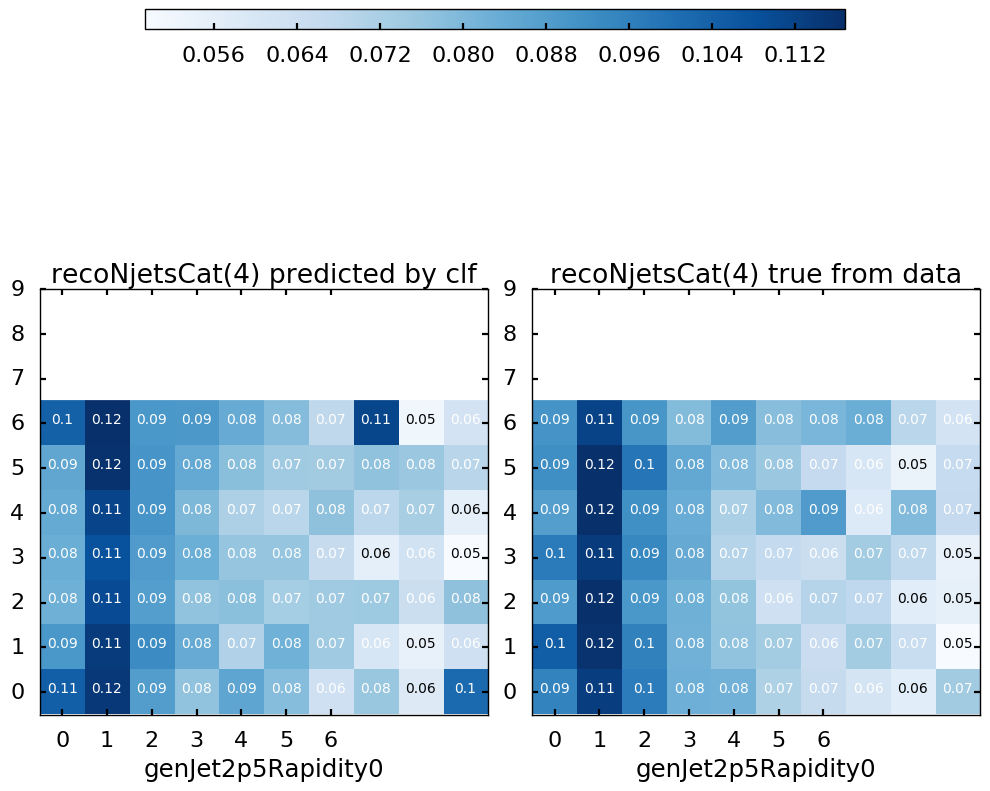

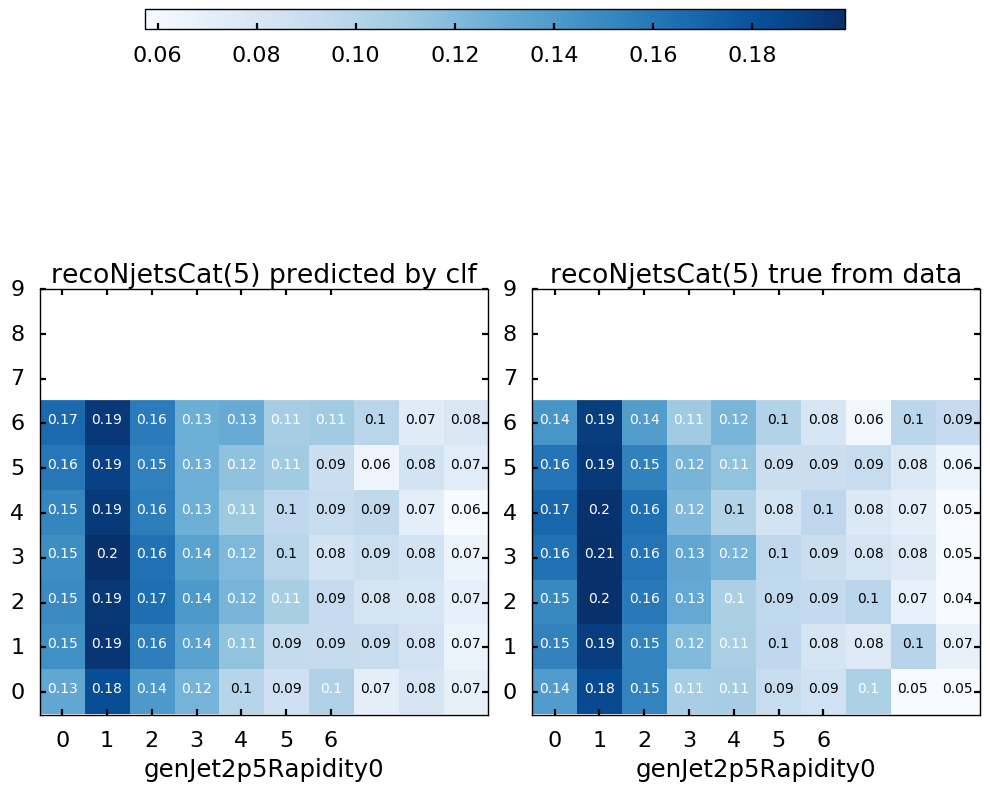

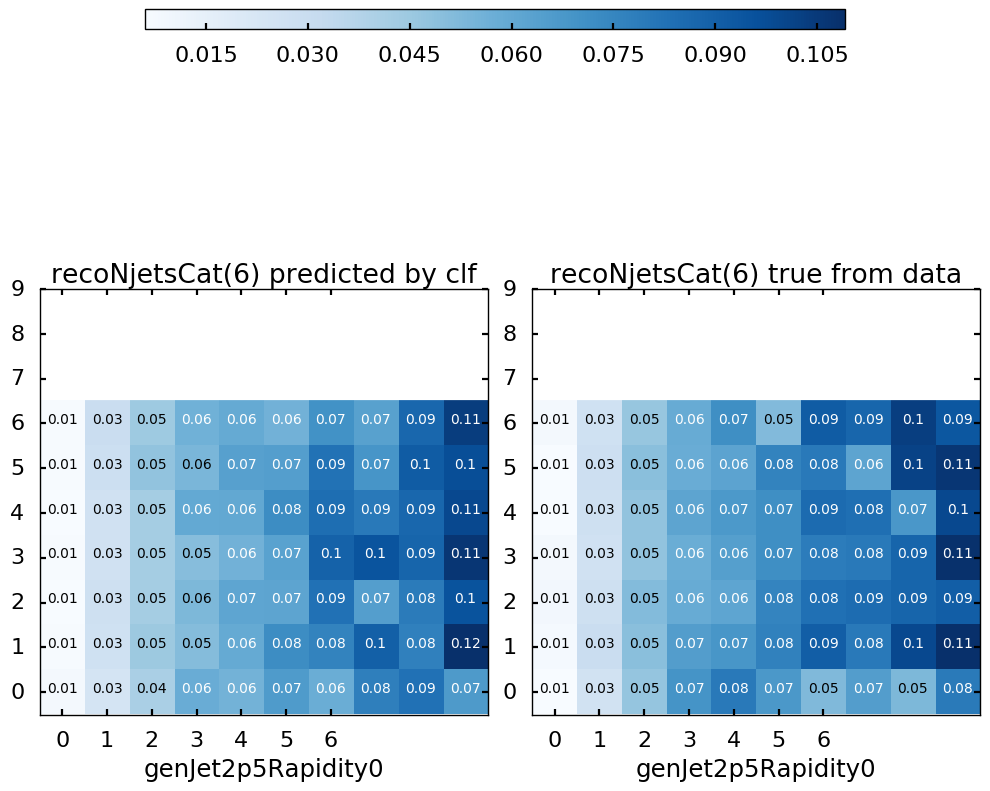

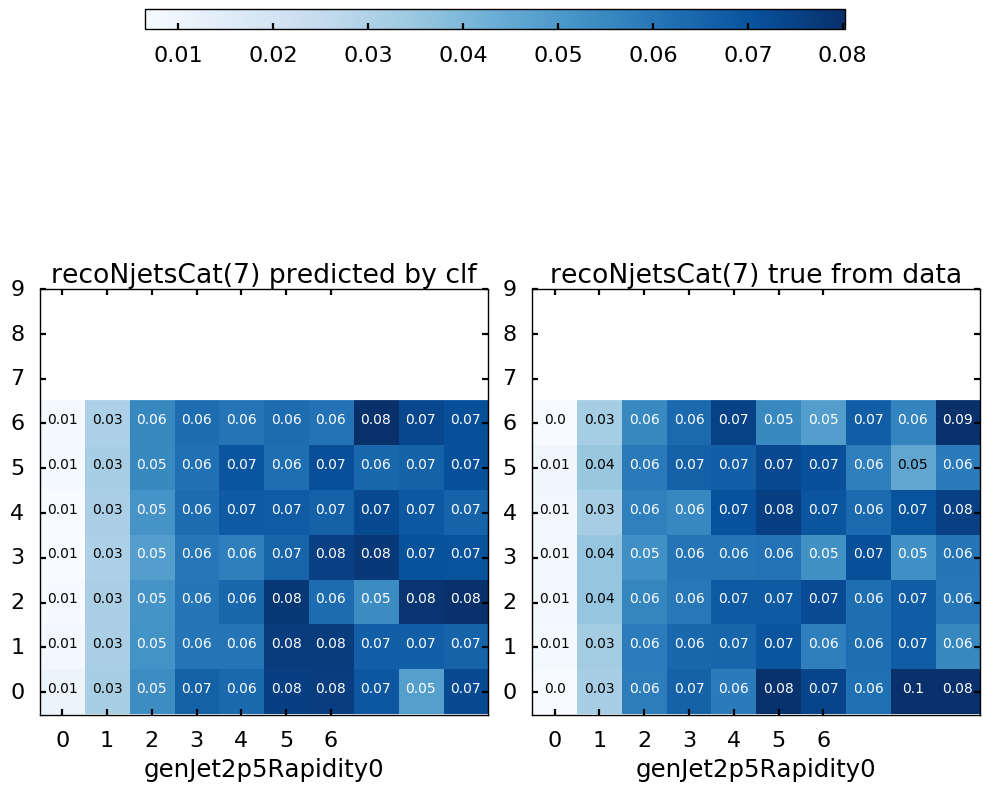

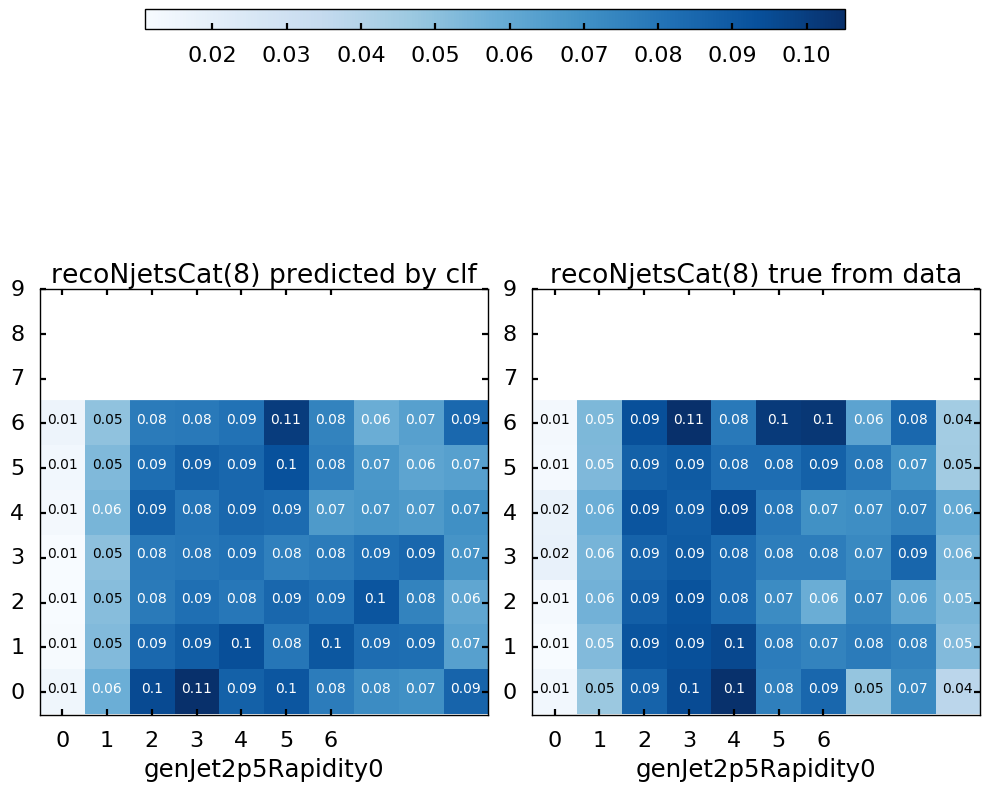

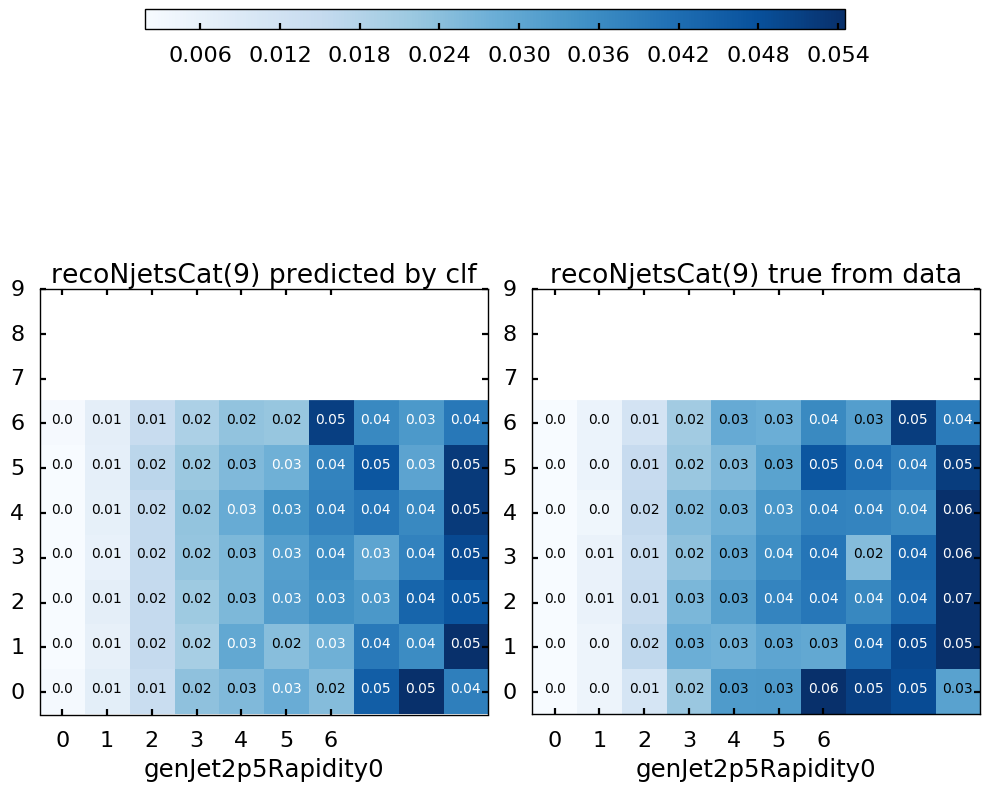

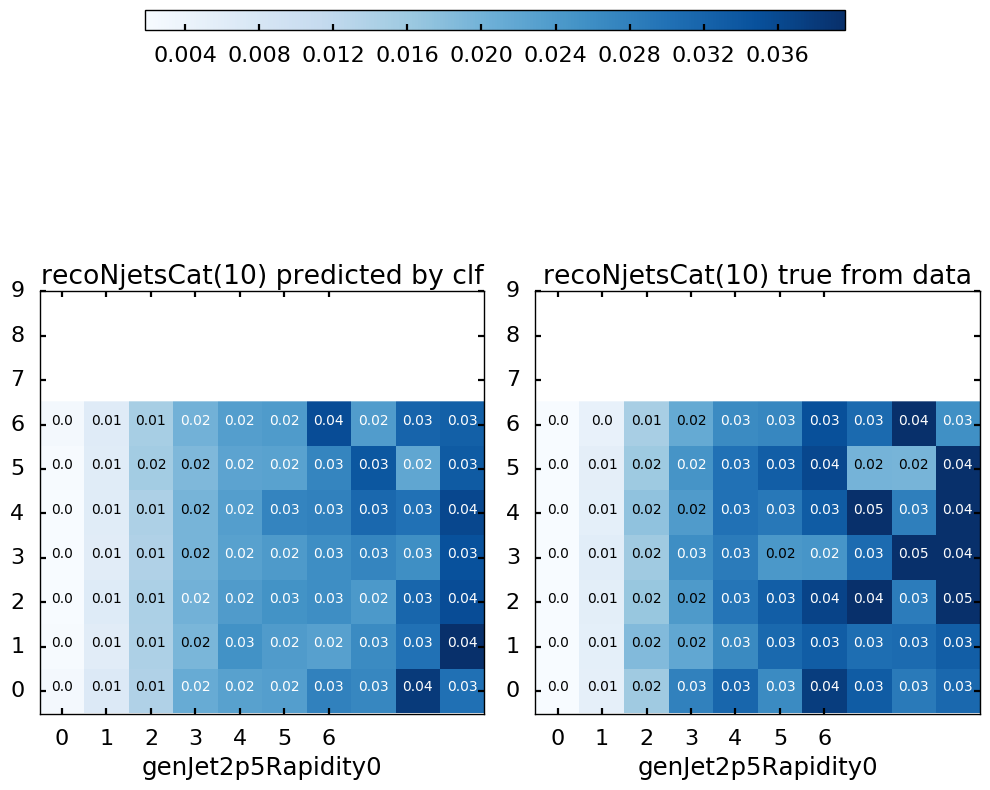

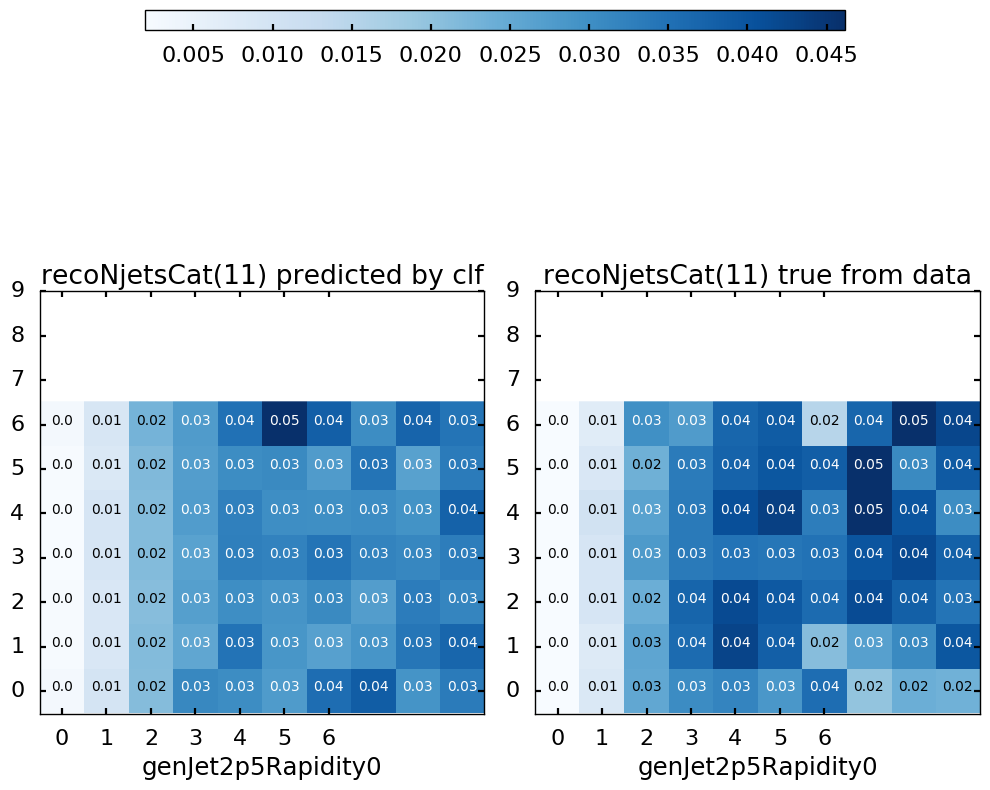

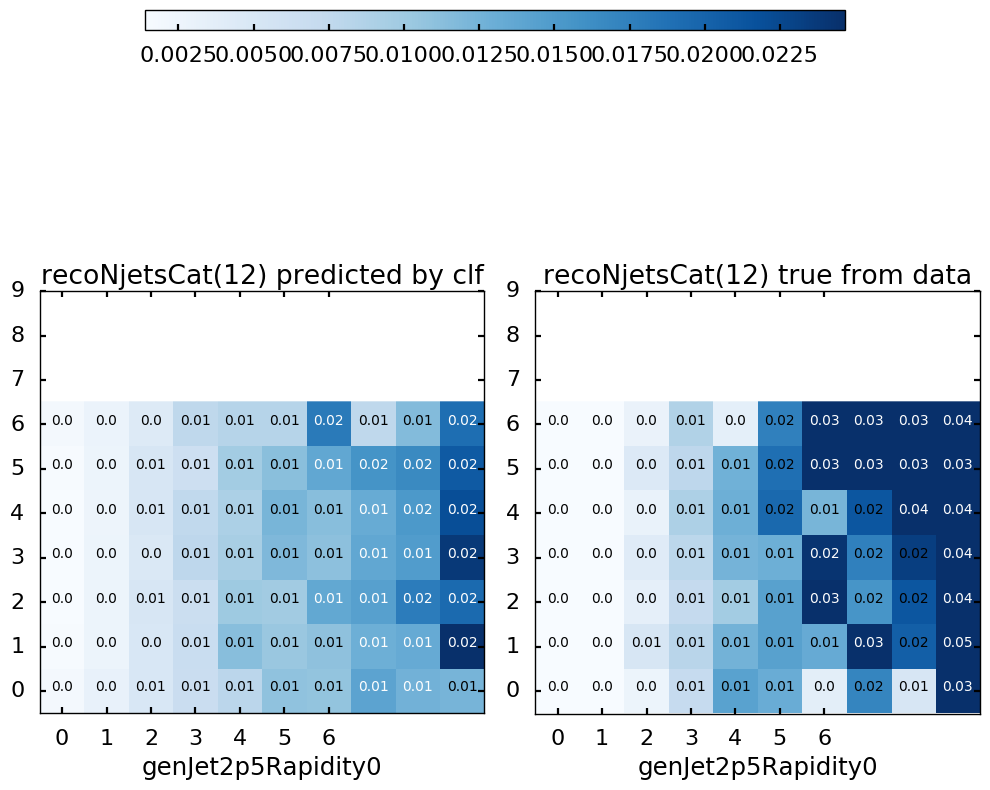

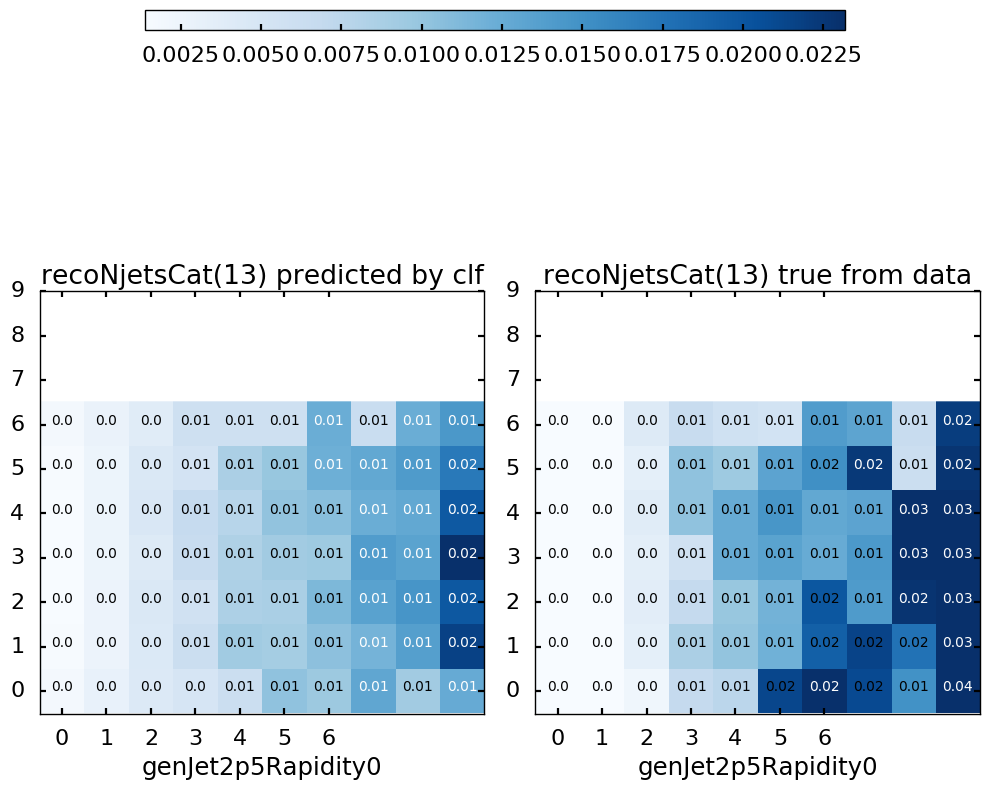

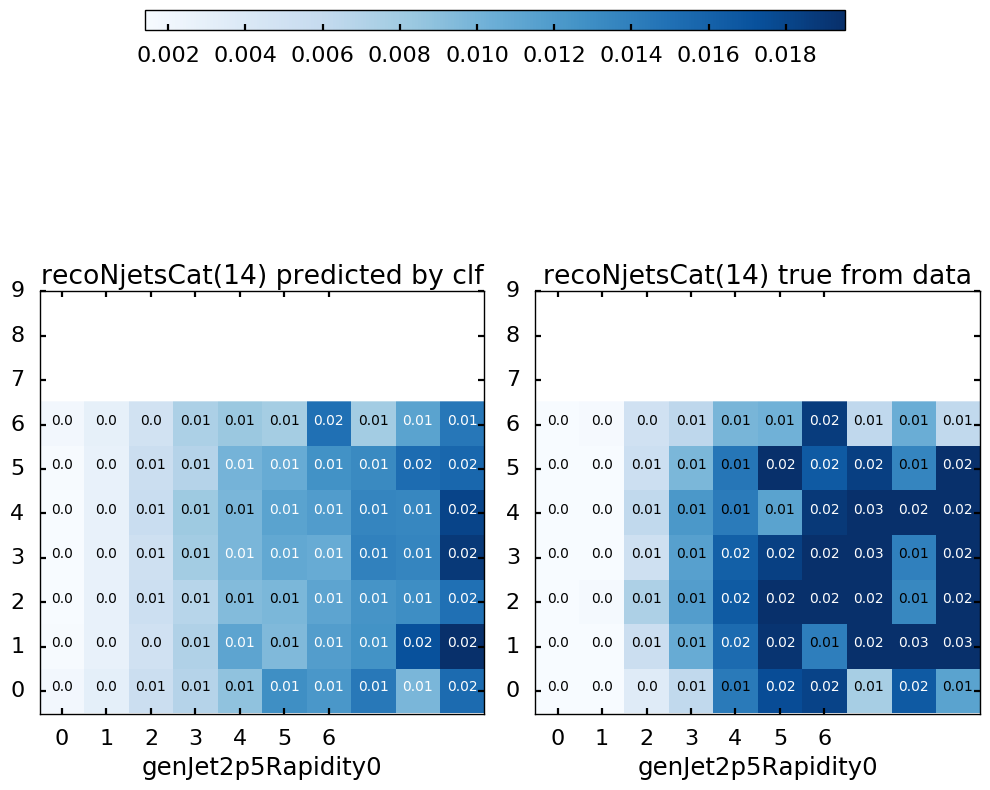

In [63]:
N_recoNjets2p5Cats = 16

for i in np.arange(N_recoNjets2p5Cats) :
    column_proba_name = 'recoNjets2p5Cat_prob_'+str(i)
    
    gb_freq  = df.groupby([x_var+'Bin',y_var+'Bin']).apply(weight_freq,"recoNjets2p5Cat",(i-1),'absweight')
    gb_proba = df_test.groupby([x_var+'Bin',y_var+'Bin']).apply(weighted_average, column_proba_name,'absweight')
    
    
    title1 ='recoNjetsCat('+str(i-1)+') predicted by clf'
    title2 ='recoNjetsCat('+str(i-1)+') true from data'
   
    plot_imshow([gb_proba,gb_freq],x_lab=x_var,y_lab=y_var,titles=[title1,title2])
    if (i==0) :
        print('perform efficiency plot as well')
        plot_imshow([gb_proba,gb_freq],x_lab=x_var,y_lab=y_var,titles=['predicted (clf) reco eff',
                                                                       'true data reco eff'],effTag=True)

    

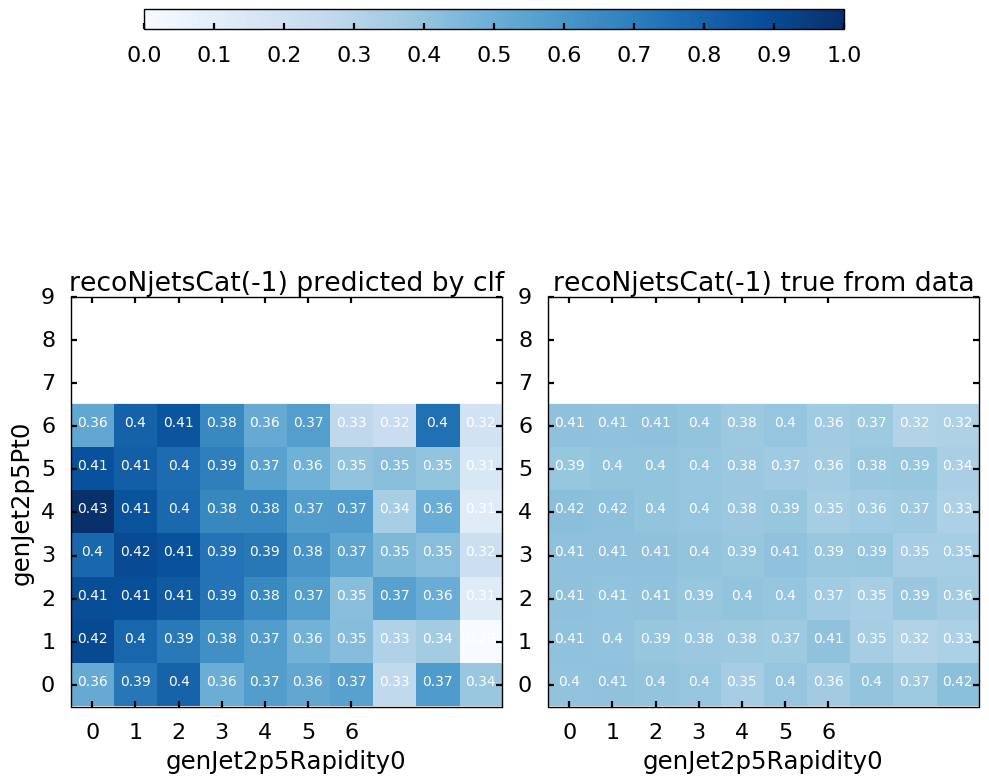

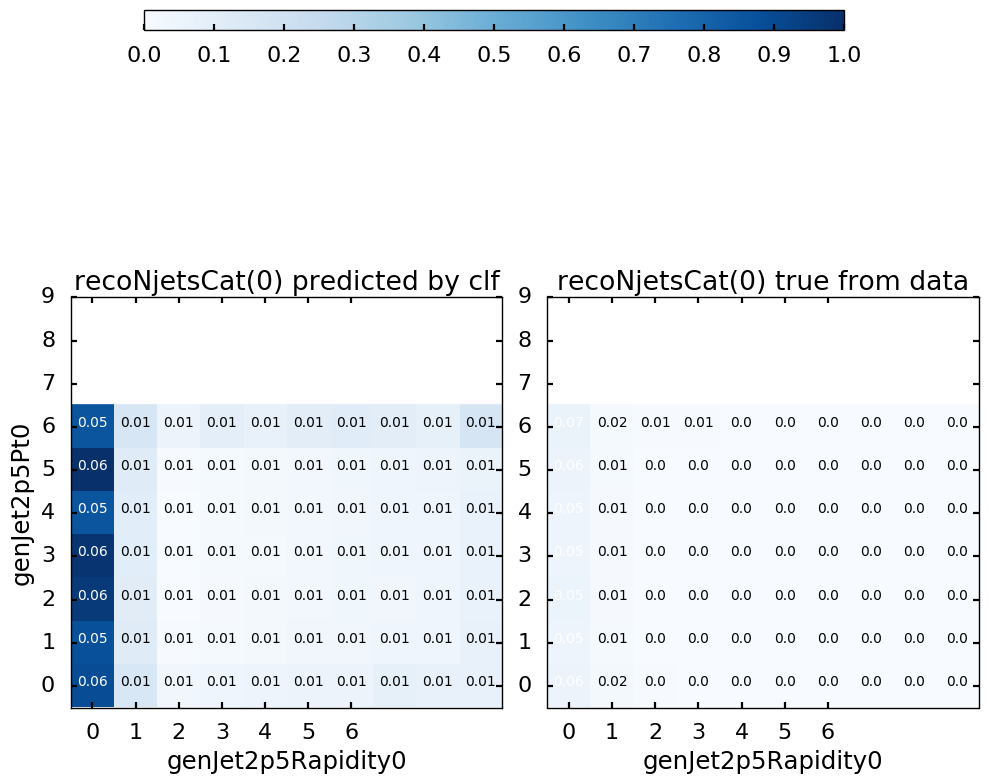

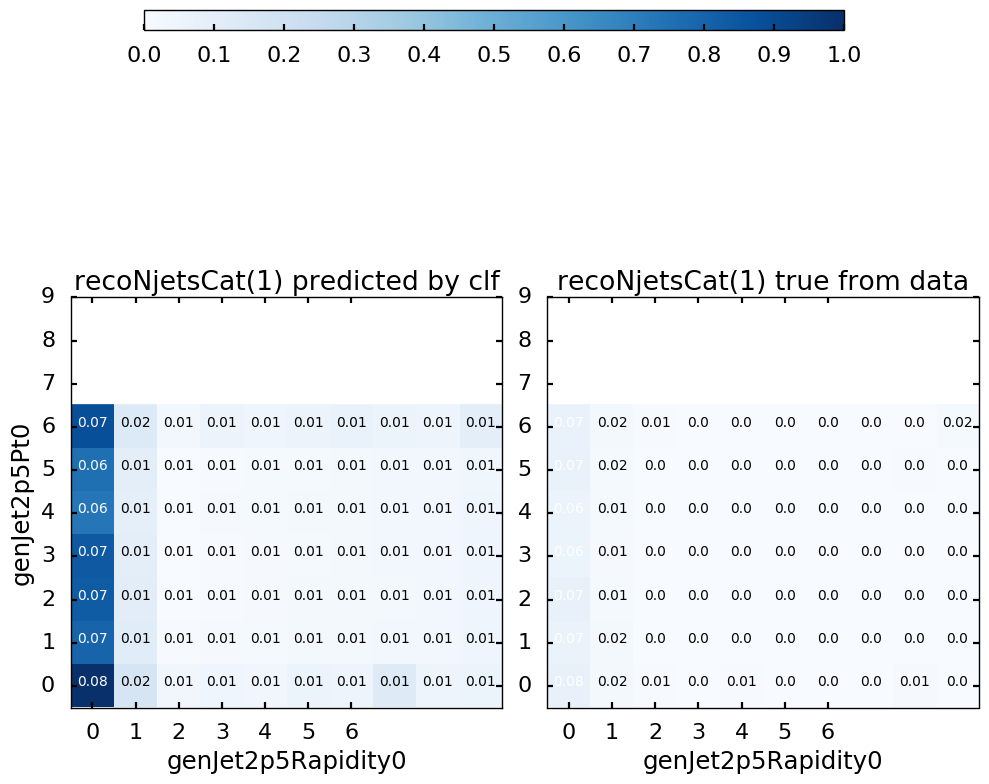


tab completion not implemented for this context

tab completion not implemented for this context

tab completion not implemented for this context

tab completion not implemented for this context

variable "plt" not defined.

variable "plt.cl" not defined.

variable "plt" not defined.

variable "plt.cl" not defined.


In [32]:
N_recoNjets2p5Cats = 1

for i in np.arange(N_recoNjets2p5Cats) :
    column_proba_name = 'recoNjets2p5Cat_prob_'+str(i)
    
    gb_freq  = df.groupby([x_var+'Bin',y_var+'Bin']).apply(weight_freq,"recoNjets2p5Cat",(i-1),'absweight')
    gb_proba = df_test.groupby([x_var+'Bin',y_var+'Bin']).apply(weighted_average, column_proba_name,'absweight')
        
    fig = plt.figure(figsize=(10,10))

    plt.subplot(121)
    plot_imshow(gb_proba,title='recoNjetsCat('+str(i-1)+') predicted by clf',x_lab=x_var,y_lab=y_var)

    plt.subplot(122)
    plot_imshow(gb_freq, title='recoNjetsCat('+str(i-1)+') true from data',  x_lab=x_var)
    
    fig.subplots_adjust(top=0.98)   
    cbar_ax = fig.add_axes([0.15, 0.97, 0.7, 0.02])
    plt.colorbar(cax=cbar_ax,orientation='horizontal')
plt.show()

In [ ]:
df_test['recoNjets2p5Cat'].max()

In [ ]:
gb_freq = df.groupby([x_var,y_var]).apply(weight_freq,"recoNjets2p5Cat",5,'absweight')

In [ ]:
gb_proba = df_test.groupby(['genJet2p5Rapidity0Bin','genJet2p5Pt0Bin']).apply(weighted_average,
                                                                              "recoNjets2p5Cat_prob_5",'absweight')

In [ ]:
plot_imshow(gb_proba)

In [ ]:
plot_imshow(gb_freq)

In [ ]:
gb_freq = df_cat_5.groupby(['genJet2p5Rapidity0Bin','genJet2p5Pt0Bin']).apply(weighted_freq,"recoNjets2p5Cat",0,
                                                                              'absweight',(norm-not_reco))

In [ ]:
np.array([2607,
487,
48,
46,
11258,
2478,
242,
221,
11373,
2531,
288,
231,
2501,
517,51,42]).sum()

In [ ]:
print('predicted proba')
plot_imshow(gb_proba)

In [ ]:
print('true proba')
plot_imshow(gb_freq)

## "ugly" plots

In [ ]:
def effPlotNjets (groupby_object) :
    
    r = groupby_object
    z = r.values
    x,y = r.index.levels
    #X,Y = np.meshgrid(x,y)
    Z = z.reshape(len(x),len(y))
    
    x_labels = np.arange(len(x))
    y_labels = np.arange(len(y))
  
    #print(X)
    #print(Y)
    
    fig, ax = plt.subplots()
    for (i, j), p in np.ndenumerate(Z):
        p = p*100
        ax.text(j+.5, i+.5, '{:0.1f}'.format(p), ha='center', va='center')
    plt.pcolormesh(Z)
 
    """
    plt.axis([x.min(),x.max(),y.min(),y.max()])
  
    plt.xlim(x.min()-.5,x.max()+.5)
    plt.ylim(y.min()-.5,y.max()+.5)
    
    plt.xticks(np.arange(len(x)))
    plt.yticks(np.arange(len(y)))
    """
    plt.show()

In [ ]:
effPlotNjets(gb_proba)

In [ ]:
effPlotNjets(gb_freq)